In [1]:
import torch
import torch.nn as nn
import torch.utils.data as data
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST
%matplotlib inline

# Check CUDA
cuda = torch.cuda.is_available()
print('GPU:', cuda)

GPU: True


In [2]:
# Parameters
BATCH_SIZE = 100
EPOCHS = 10
LATENT_DIM = 2
LR = 1e-3
WEIGHT_DECAY = 0

In [3]:
# Image processing
Train_Data = MNIST(root='../Assignment3_dataset/MNIST', train=True, transform=transforms.ToTensor(), download=True)
Train_DataLoader = data.DataLoader(dataset=Train_Data, batch_size=BATCH_SIZE, shuffle=True)

if not os.path.exists("../Assignment3/params"):
    os.mkdir("../Assignment3/params")
if not os.path.exists("../Assignment3/img"):
    os.mkdir("../Assignment3/img")

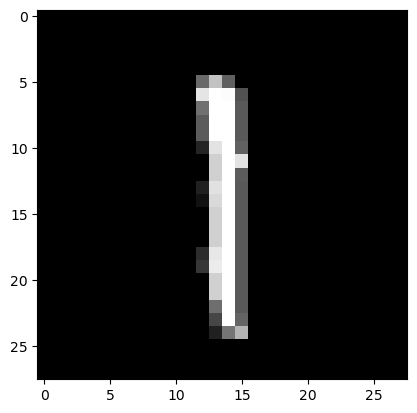

In [4]:
idx = np.random.randint(0, len(Train_Data))
img = Train_Data[idx][0].numpy().squeeze()
plt.imshow(img, cmap='gray')
plt.show()

In [4]:
# Auto-Encoder

class AutoEncoderModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU(),
        )  # N,3,14,14
        self.conv2 = nn.Sequential(
            nn.Conv2d(3, 6, 3, 2, 1),
            nn.BatchNorm2d(6),
            nn.ReLU(),
        )  # N,6,7,7

        self.fc1 = nn.Sequential(
            nn.Linear(6 * 7 * 7, 128),
        )  # N,128

        self.fc2 = nn.Sequential(
            nn.Linear(128, 6 * 7 * 7),
            nn.BatchNorm1d(6 * 7 * 7),
            nn.ReLU()
        )  # 7,7

        # DeConv
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(6, 3, 3, 2, 1, output_padding=1),
            nn.BatchNorm2d(3),
            nn.ReLU()
        )  # 14,14
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(3, 1, 3, 2, 1, output_padding=1),
            nn.ReLU()
        )  # 28.28

    def forward(self, x):
        # Encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x2 = torch.reshape(x2, [x2.size(0), -1])
        code = self.fc1(x2)

        # Decoder
        y1 = self.fc2(code)
        y1 = torch.reshape(y1, [y1.size(0), 6, 7, 7])
        y2 = self.conv3(y1)
        out = self.conv4(y2)

        return out

In [9]:
# Define model

def Train(self):
    
    # Loss function
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(self.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

    # Train
    for epoch in range(EPOCHS):
        for step, (x, y) in enumerate(Train_DataLoader):
            if cuda:
                x = x.cuda()
                y = y.cuda()
            output = self(x)
            loss = criterion(output, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if step % 100 == 0:
                print('Epoch:', epoch, '|Step:', step, '|train loss:%.4f' % loss.cpu().data.numpy())
        # Save model
        torch.save(self.state_dict(), '../Assignment3/params/ae_params.pkl')
        # Print Last Image
        save_image(output.cpu().data[:64], '../Assignment3/img/ae_img.png', nrow=8)

In [11]:
# Train
model = AutoEncoderModel()
if cuda:
    model.cuda()
Train(model)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
